# Threader Earrings Generation Demo

This notebook demonstrates the complete optimization pipeline for generating **threader earrings** using:

- **Base SD 1.5 model** (baseline)
- **Fine-tuned LoRA adapter** for threader earrings
- **Special token** (`phol`) for enhanced grounding  
- **Optimized parameters** (CEuler Ancestral sampler)
- **Custom prompt weighting** using native diffusers syntax

## Target Prompt:
`"14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light"`


## Setup and Imports


In [1]:
import torch
import os
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import matplotlib.pyplot as plt
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


PyTorch version: 2.8.0
CUDA available: False
Device: cpu


## Configuration


In [ ]:
# Target prompt for threader earrings
PROMPT = "14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light"

# LoRA adapter path for threader earrings
LORA_PATH = "threader/checkpoint/pytorch_lora_weights.safetensors"

# Special token for threader earrings (from training)
SPECIAL_TOKEN = "phol"

# Generation parameters
SEED = 42
STEPS = 50
BASELINE_CFG = 7.5
OPTIMIZED_CFG = 9.0

print(f"✅ Target prompt: {PROMPT}")
print(f"✅ LoRA path: {LORA_PATH}")
print(f"✅ Special token: {SPECIAL_TOKEN}")
print(f"✅ Parameters: {STEPS} steps, baseline CFG={BASELINE_CFG}, optimized CFG={OPTIMIZED_CFG}")


✅ Target prompt: 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
✅ LoRA path: threader/checkpoint/pytorch_lora_weights.safetensors
✅ Special token: phol
✅ Parameters: 50 steps, baseline CFG=7.5, optimized CFG=9.0


## Pipeline Setup


In [3]:
def setup_pipeline():
    """Setup SD 1.5 pipeline with optimal configuration"""
    print("🔧 Loading SD 1.5 pipeline...")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if device == "cuda" else torch.float32
    variant = "fp16" if device == "cuda" else None
    
    pipeline = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=dtype,
        variant=variant
    )
    
    # Set optimal sampler (Euler Ancestral from human evaluation)
    pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
        pipeline.scheduler.config
    )
    
    pipeline.to(device)
    
    # Memory optimizations
    try:
        pipeline.enable_model_cpu_offload()
        print("✅ Using model CPU offloading")
    except:
        try:
            pipeline.enable_attention_slicing()
            print("✅ Using attention slicing")
        except:
            print("⚠️ No memory optimization available")
    
    print(f"✅ Pipeline ready on {device}")
    return pipeline

# Initialize pipeline
pipeline = setup_pipeline()


🔧 Loading SD 1.5 pipeline...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Using model CPU offloading
✅ Pipeline ready on cpu


## Prompt Enhancement Functions


In [4]:
def create_optimized_prompt(prompt):
    """Apply threader-specific optimizations to the prompt"""
    
    # Add special token before "threader"
    enhanced_prompt = prompt.replace("threader", f"{SPECIAL_TOKEN} threader")
    
    # Apply custom attention weighting for threader earrings
    enhanced_prompt = enhanced_prompt.replace("rose-gold", "(rose-gold:1.2)")
    enhanced_prompt = enhanced_prompt.replace(f"{SPECIAL_TOKEN} threader", f"({SPECIAL_TOKEN} threader:1.2)")
    enhanced_prompt = enhanced_prompt.replace("bezel-set", "(bezel-set:1.2)")
    enhanced_prompt = enhanced_prompt.replace("diamond", "(diamond:1.2)")
    enhanced_prompt = enhanced_prompt.replace("lifestyle", "(lifestyle:1.2)")
    enhanced_prompt = enhanced_prompt.replace("macro", "(macro:1.2)")
    
    return enhanced_prompt

# Test the prompt enhancement
original_prompt = PROMPT
optimized_prompt = create_optimized_prompt(PROMPT)

print("📝 PROMPT COMPARISON:")
print(f"Original:  {original_prompt}")
print(f"Enhanced:  {optimized_prompt}")
print(f"\\n🔧 Transformations applied:")
print(f"  • Added special token: '{SPECIAL_TOKEN}' before 'threader'")
print(f"  • Applied 1.2x attention weighting to jewelry terms")


📝 PROMPT COMPARISON:
Original:  14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
Enhanced:  14k (rose-gold:1.2) (phol threader:1.2) earrings, (bezel-set:1.2) round lab (diamond:1.2) ends, (lifestyle:1.2) (macro:1.2) shot, soft natural light
\n🔧 Transformations applied:
  • Added special token: 'phol' before 'threader'
  • Applied 1.2x attention weighting to jewelry terms


## Generate Baseline Image

First, let's generate the baseline image using the original prompt with default settings:


🔸 Generating baseline image...
Prompt: 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
Parameters: CFG=7.5, Steps=50


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Baseline image generated!


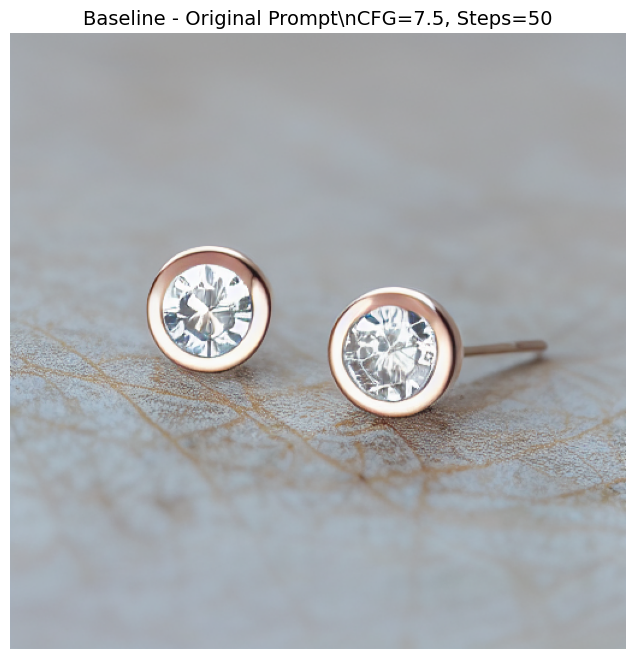

In [5]:
print("🔸 Generating baseline image...")
print(f"Prompt: {PROMPT}")
print(f"Parameters: CFG={BASELINE_CFG}, Steps={STEPS}")

# Generate baseline image
generator = torch.Generator(device=pipeline.device).manual_seed(SEED)

baseline_image = pipeline(
    prompt=PROMPT,
    num_inference_steps=STEPS,
    guidance_scale=BASELINE_CFG,
    generator=generator,
    height=512,
    width=512
).images[0]

print("✅ Baseline image generated!")

# Display baseline image
plt.figure(figsize=(8, 8))
plt.imshow(baseline_image)
plt.title(f"Baseline - Original Prompt\\nCFG={BASELINE_CFG}, Steps={STEPS}", fontsize=14)
plt.axis('off')
plt.show()


## Load LoRA Adapter and Generate Optimized Image

Now let's load the threader earrings LoRA adapter and generate an optimized image:


In [ ]:
# Check if LoRA file exists
if os.path.exists(LORA_PATH):
    print(f"🔧 Loading LoRA adapter from: {LORA_PATH}")
    pipeline.load_lora_weights(LORA_PATH)
    print("✅ LoRA adapter loaded successfully!")
    lora_loaded = True
else:
    print(f"⚠️ LoRA adapter not found: {LORA_PATH}")
    print("⚠️ Proceeding without LoRA (will still show prompt optimization effects)")
    lora_loaded = False

print("\\n🔹 Generating optimized image...")
print(f"Prompt: {optimized_prompt}")
print(f"Parameters: CFG={OPTIMIZED_CFG}, Steps={STEPS}")
if lora_loaded:
    print(f"LoRA: threader earrings adapter")

# Generate optimized image
generator = torch.Generator(device=pipeline.device).manual_seed(SEED)

optimized_image = pipeline(
    prompt=optimized_prompt,
    num_inference_steps=STEPS,
    guidance_scale=OPTIMIZED_CFG,
    generator=generator,
    height=512,
    width=512
).images[0]

print("✅ Optimized image generated!")

# Display optimized image
plt.figure(figsize=(8, 8))
plt.imshow(optimized_image)
lora_text = " + LoRA" if lora_loaded else " (No LoRA)"
plt.title(f"Optimized - Enhanced Prompt{lora_text}\\nCFG={OPTIMIZED_CFG}, Steps={STEPS}", fontsize=14)
plt.axis('off')
plt.show()

# Unload LoRA for clean state
if lora_loaded:
    try:
        pipeline.unload_lora_weights()
        print("🔄 LoRA adapter unloaded")
    except:
        print("⚠️ Could not unload LoRA adapter")


⚠️ LoRA adapter not found: threader/checkpoint/pytorch_lora_weights.safetensors
⚠️ Proceeding without LoRA (will still show prompt optimization effects)
\n🔹 Generating optimized image...
Prompt: 14k (rose-gold:1.2) (phol threader:1.2) earrings, (bezel-set:1.2) round lab (diamond:1.2) ends, (lifestyle:1.2) (macro:1.2) shot, soft natural light
Parameters: CFG=9.0, Steps=50


  0%|          | 0/50 [00:00<?, ?it/s]

## Side-by-Side Comparison

Let's compare both images side by side to see the optimization effects:


In [ ]:
# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Baseline image
ax1.imshow(baseline_image)
ax1.set_title(f"Baseline\\nOriginal Prompt\\nCFG={BASELINE_CFG}, {STEPS} steps", fontsize=14, pad=20)
ax1.axis('off')

# Optimized image
ax2.imshow(optimized_image)
lora_text = " + LoRA" if lora_loaded else " (No LoRA)"
ax2.set_title(f"Optimized\\nEnhanced Prompt{lora_text}\\nCFG={OPTIMIZED_CFG}, {STEPS} steps", fontsize=14, pad=20)
ax2.axis('off')

plt.suptitle('Threader Earrings Generation: Baseline vs Optimized', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

print("\\n🎯 OPTIMIZATION SUMMARY:")
print(f"✅ Prompt: Added '{SPECIAL_TOKEN}' token + attention weighting")
print(f"✅ CFG Scale: {BASELINE_CFG} → {OPTIMIZED_CFG}")
print(f"✅ LoRA: {'Loaded threader adapter' if lora_loaded else 'Not available'}")
print(f"✅ Sampler: Euler Ancestral (optimal from human evaluation)")
print(f"✅ Steps: {STEPS} (balanced speed/quality)")
